In [51]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [52]:
import gc
import time
from copy import deepcopy
from pathlib import Path
from pprint import pprint

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import torch
from ott.geometry import pointcloud
from ott.solvers import linear

from fm4ar.nested_sampling.posteriors import load_posterior

In [53]:
def normalize_weights(weights: np.ndarray) -> np.ndarray:
    """
    Normalize weights such that sum(weights) == len(weights).
    """

    return weights * len(weights) / np.sum(weights)


def get_effective_sample_size(weights: np.ndarray) -> float:
    """
    Compute the effective sample size.
    """

    weights = normalize_weights(weights)
    return np.sum(weights) ** 2 / np.sum(weights ** 2)


def get_subsample_idx(a: np.ndarray, target_size: int = 50_000) -> int:
    """
    Find the smallest index `n` such that 
    `get_effective_sample_size(a[:n]) >= target_size`.
    """

    low, high = 0, len(a)
    n = high

    while low <= high:
        mid = (low + high) // 2
        if get_effective_sample_size(a[:mid]) >= target_size:
            n = mid
            high = mid - 1
        else:
            low = mid + 1

    return n


def get_random_sample(
    samples: np.ndarray, 
    weights: np.ndarray | None, 
    n: int = 1000,
) -> jnp.ndarray:

    if weights is not None:
        weights = deepcopy(weights)
    else:
        weights = np.ones(len(samples))

    weights /= np.sum(weights)
    
    idx = np.random.choice(a=len(weights), size=n, replace=True, p=weights)

    return jnp.array(samples[idx])

# Load posteriors

In [54]:
workshop_dir = Path("/home/tgebhard/projects/fm4ar/experiments/aaai-workshop")
target_size = 50_000
results = {}

In [55]:
# Load results from unconditional flow as the reference
file_path = workshop_dir / "unconditional-flow/importance_sampling/importance_sampling_results_minimized.hdf"
with h5py.File(file_path, "r") as f:
    samples = np.array(f["theta"])
    weights = np.array(f["weights"])

# Drop the maximum weight (crazy outlier)
idx = np.argmax(weights)
mask = np.ones_like(weights).astype(bool)
mask[idx] = False
samples = samples[mask]
weights = weights[mask]

weights = normalize_weights(weights)

# Get effective sample size
print(f"Sampling efficiency:   {100 * get_effective_sample_size(weights) / len(weights):,.2f}%")
print(f"Effective sample size: {get_effective_sample_size(weights):,.0f}")

# Store in dict
results["reference"] = dict(
    label="Reference",
    samples=samples,
    weights=weights,
)

Sampling efficiency:   6.22%
Effective sample size: 616,816


In [56]:
# Load nautilus posterior
experiment_dir = Path("/home/tgebhard/projects/fm4ar/scripts/nested_sampling/results/nautilus/15_high-res")
samples, weights = load_posterior(experiment_dir=experiment_dir)

# Compute sampling effiency before limiting the number of effective samples
print(f"Sampling efficiency:   {100 * get_effective_sample_size(weights) / len(weights):,.2f}%")

# Limit to target_size
n = get_subsample_idx(weights, target_size)
samples = samples[:n]
weights = normalize_weights(weights[:n])

# Get effective sample size
print(f"Effective sample size: {get_effective_sample_size(weights):,.1f}")

# Store in dict
results["nautilus"] = dict(
    label="nautilus",
    samples=samples,
    weights=weights,
)

Sampling efficiency:   2.13%
Effective sample size: 50,000.0


In [57]:
for name in ("fmpe", "npe"):

    print(name)

    # Construct label
    label = name.upper()

    # Load results from HDF file
    file_path = workshop_dir / name / "importance_sampling" / "importance_sampling_results.hdf"
    with h5py.File(file_path, "r") as f:
        samples = np.array(f["theta"])
        weights = np.array(f["weights"])

    # Store the first `target_size` samples as the "raw" results
    results[f"{name}_raw"] = dict(
        label=label,
        samples=samples[:target_size],
        weights=np.ones(target_size),
    )
    
    # Compute sampling effiency before limiting the number of effective samples
    print(f"Sampling efficiency:   {100 * get_effective_sample_size(weights) / len(weights):,.2f}%")
    
    # Limit to `target_size` effective samples
    n = get_subsample_idx(weights, target_size)
    samples = samples[:n]
    weights = normalize_weights(weights[:n])
    print(f"Subset index:          {n:,d}")
    
    # Get effective sample size
    print(f"Effective sample size: {get_effective_sample_size(weights):,.1f}")

    # Compute sampling effiency after limiting the number of effective samples
    print(f"Sampling efficiency:   {100 * get_effective_sample_size(weights) / len(weights):,.2f}%")
    
    # Store in dict
    results[f"{name}_is"] = dict(
        label=f"{label}+IS",
        samples=samples,
        weights=weights,
    )
    print()

fmpe
Sampling efficiency:   10.69%
Subset index:          384,691
Effective sample size: 50,000.4
Sampling efficiency:   13.00%

npe
Sampling efficiency:   2.66%
Subset index:          1,999,354
Effective sample size: 50,000.7
Sampling efficiency:   2.50%



In [58]:
results.keys()

dict_keys(['reference', 'nautilus', 'fmpe_raw', 'fmpe_is', 'npe_raw', 'npe_is'])

# Compute optimal transport distance between two samples

In [59]:
gc.collect()
torch.cuda.empty_cache()

In [60]:
# Fix random seed
np.random.seed(42)
torch.manual_seed(42)

d = 16
n_x = 10_000
n_y = 10_000
n_rounds = 100

for (key, no_weights) in [
    ("reference", False),
    ("nautilus", False),
    ("npe_raw", True),
    ("npe_is", False),
    ("fmpe_raw", True),
    ("fmpe_is", False),
]:

    start_time = time.time()
    print(key, end="")

    results[key]["upper_bounds"] = []
    
    for _ in range(n_rounds):

        print(".", end="")
    

        # Get sample from reference
        x = get_random_sample(
            samples=results["reference"]["samples"], 
            weights=results["reference"]["weights"], 
            n=n_x,
        )
        
        # Get sample from estimate
        y = get_random_sample(
            samples=results[key]["samples"], 
            weights=(None if no_weights else results[key]["weights"]), 
            n=n_y,
        )
    
        # Solve optimal transport
        geom = pointcloud.PointCloud(x, y, cost_fn=None)
        solve_fn = jax.jit(linear.solve)
        ot = solve_fn(geom)
    
        # Compute bounds on OT cost
        # lower = float(ot.dual_cost)
        upper = float(ot.primal_cost)

        # Store results
        results[key]["upper_bounds"].append(upper)

        del x
        del y
        del geom
        del ot
    
    print(f" Done! ({time.time() - start_time:.2f} seconds)")

reference.................................................................................................... Done! (53.05 seconds)
nautilus.................................................................................................... Done! (41.32 seconds)
npe_raw.................................................................................................... Done! (42.82 seconds)
npe_is.................................................................................................... Done! (36.68 seconds)
fmpe_raw.................................................................................................... Done! (41.53 seconds)
fmpe_is.................................................................................................... Done! (34.00 seconds)


In [61]:
for key in results.keys():
    label  = results[key]["label"]
    mean = np.mean(results[key]["upper_bounds"])
    std = np.std(results[key]["upper_bounds"])
    print(f'{label:<10}: {mean:.2f}+-{std:.2f}')

Reference : 234.07+-2.79
nautilus  : 240.29+-6.02
FMPE      : 420.43+-51.08
FMPE+IS   : 233.50+-3.35
NPE       : 940.80+-176.67
NPE+IS    : 235.00+-3.57


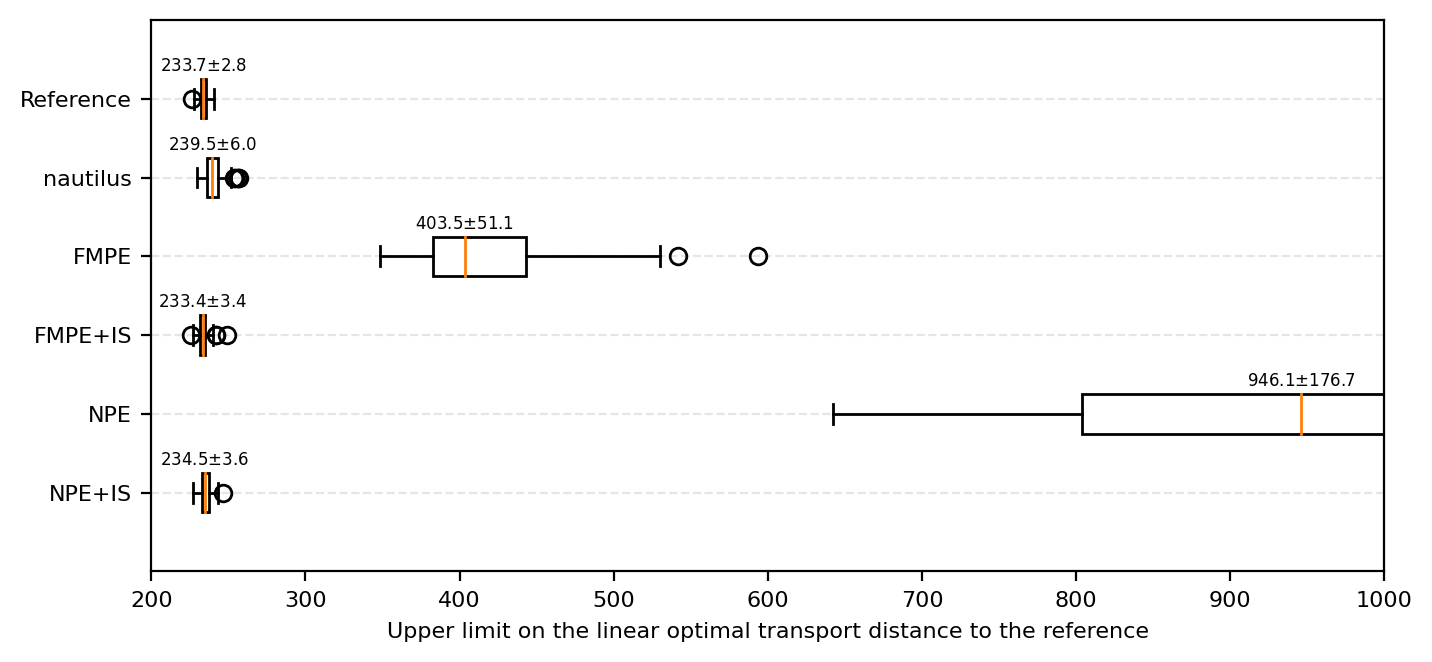

In [63]:
pad_inches = 0.05
fig, ax = plt.subplots(figsize=(17.0 / 2.54 - 2 * pad_inches, 8 / 2.54 - 2 * pad_inches))
fig.tight_layout(pad=0)

all_data = [results[key]["upper_bounds"] for key in results.keys()][::-1]
labels = [results[key]["label"] for key in results.keys()][::-1]

bplot = ax.boxplot(
    all_data,
    vert=False,
    patch_artist=True,
    labels=labels,
)

for patch in bplot['boxes']:
    patch.set_facecolor("white")

for i, key in enumerate(results.keys()):
    median = np.median(results[key]["upper_bounds"])
    std = np.std(results[key]["upper_bounds"])
    label = rf'{median:.1f}$\pm${std:.1f}'
    ax.text(x=median, y=6 - i + 0.3, s=label, va="bottom", ha="center", fontsize=6)

ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)

ax.yaxis.grid(which="both", color="black", ls="--", alpha=0.1)

ax.set_xlabel('Upper limit on the linear optimal transport distance to the reference', fontsize=8)
ax.set_xlim(200, 1000)
ax.set_ylim(0, 7)

plt.savefig("ot-distances.pdf", dpi=300, bbox_inches="tight", pad_inches=0.01)
plt.show()